In [1]:
import pandas as pd, numpy as np
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision 
from torchvision.utils import make_grid
from torchvision import transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

### Loading packages

In [2]:
import sys
from pathlib import Path

here_path = Path().resolve()
repo_path = here_path.parents[0]
sys.path.append(str(repo_path))

In [3]:
from py.utils import *

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

DATA_PATH = os.getenv('DATA_PATH')
MODEL_PATH = os.getenv('MODEL_PATH')
DATA_PATH, MODEL_PATH

('/media/felipe/DATA19/datasets/', '/media/felipe/DATA19/models/')

### Loading data

In [5]:
# Once you downloaded the ds, specify the path to training set
TRAINING_IMGS_PATH = f'{DATA_PATH}17kgraffiti/images/train/'

train_bboxes = pd.read_pickle(f'{DATA_PATH}17kgraffiti/annotations/train/bboxes.pkl')
test_bboxes = pd.read_pickle(f'{DATA_PATH}17kgraffiti/annotations/test/bboxes.pkl')

In [6]:
test_bboxes

FileName  bbox_count  \
0     10005509946_302a7e4b81_c           2   
1     10008085844_aa0cb2ec39_c           1   
2     10034314145_18c252992b_c           3   
3     10082715963_16bde463ce_c           1   
4     10145984386_43704ec26a_c           2   
...                        ...         ...   
1731   9872699124_a429e0c1c2_c           1   
1732   9872747895_7133f67441_c           1   
1733   9948743143_dfb2d78b67_c           1   
1734   9950193234_f079af9806_c           1   
1735  29566606407_70d4dac576_c           5   

                                                   bbox  
0             [[7, 108, 153, 377], [186, 62, 716, 387]]  
1                                  [[18, 39, 773, 241]]  
2     [[3, 93, 144, 303], [85, 58, 259, 288], [226, ...  
3                                 [[38, 123, 734, 460]]  
4             [[398, 61, 740, 213], [12, 58, 202, 206]]  
...                                                 ...  
1731                               [[32, 33, 623, 257]]  
1732                               [[46, 11, 756, 242]]  
1733                               [[52, 35, 738, 183]]  
1734                               [[90, 41, 768, 228]]  
1735  [[63, 170, 344, 290], [354, 174, 509, 277], [5...  

[1736 rows x 3 columns]

In [7]:
#Report the number of graffiti instances per set

print(f'Train set \t --> \t # of single bbox: \t {train_bboxes[train_bboxes.bbox_count==1]["bbox_count"].sum()}')
print(f'Train set \t --> \t # of multiple bbox: \t {train_bboxes[train_bboxes.bbox_count>1]["bbox_count"].sum()}')
print('------------------------------------------------------')
print(f'Test set \t --> \t # of single bbox: \t {test_bboxes[test_bboxes.bbox_count==1]["bbox_count"].sum()}')
print(f'Test set \t --> \t # of multiple bbox: \t {test_bboxes[test_bboxes.bbox_count>1]["bbox_count"].sum()}')
print('=======================================================')
print(f'Total number of bboxes in the dataset: \t \t {train_bboxes["bbox_count"].sum()+test_bboxes["bbox_count"].sum()}')


Train set 	 --> 	 # of single bbox: 	 4115
Train set 	 --> 	 # of multiple bbox: 	 9704
------------------------------------------------------
Test set 	 --> 	 # of single bbox: 	 1004
Test set 	 --> 	 # of multiple bbox: 	 2008
Total number of bboxes in the dataset: 	 	 16831


In [8]:
# Construct the Graffiti dataset for pytorch Dataloader 
# and demonstrate some example images with bboxes of training set
# the GraffitiData is called from _util.py
train_ds = GraffitiDataset(TRAINING_IMGS_PATH,
                           train_bboxes,
                           w=224,
                           h=224,
                           transforms=get_train_transform())

# Providing the dataset for pytoch dataloader
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)

(np.float64(-0.5), np.float64(910.5), np.float64(910.5), np.float64(-0.5))

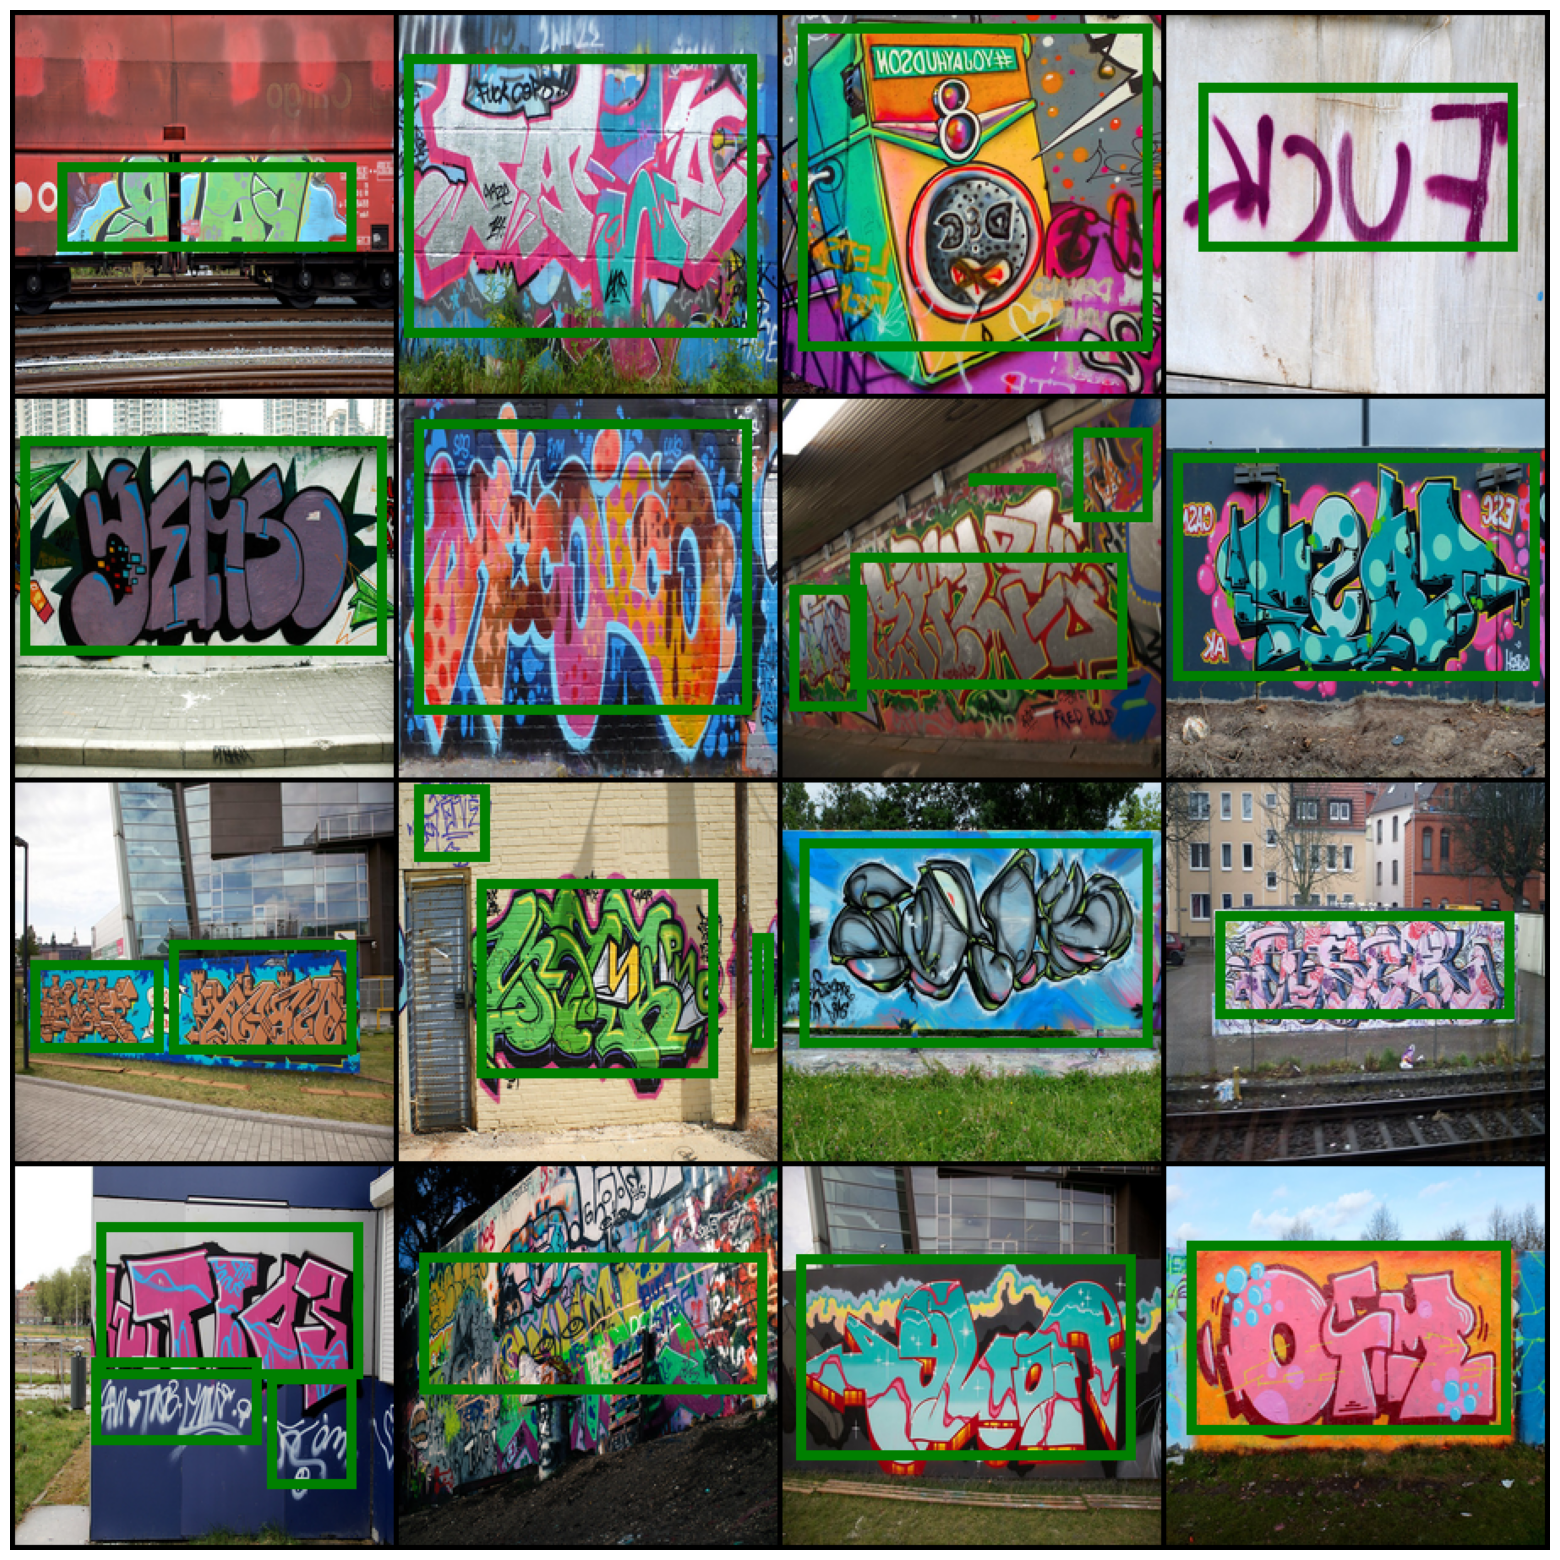

In [9]:
images, targets, img_id = next(iter(train_loader))
images = list(image.to("cpu") for image in images)

targets = [{k: v.to("cpu") for k, v in t.items()} for t in targets]
images_bboxes = [plot_img_bbox(images[i],targets[i]['boxes'].cpu().detach().numpy()).permute(2,1,0) 
                 for i in range(len(images)) if len(targets[i]['boxes'])>=1]


generated = make_grid(images_bboxes, nrow=4, padding=3, normalize=False, scale_each=False, pad_value=0)
plt.subplots(figsize=(20,20))
plt.imshow(generated.cpu().detach().numpy().transpose(2,1,0))
plt.axis('off')